In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

from postprocess_utils import *
import pandas as pd
import sqlalchemy

In [3]:
from utils import gen_data, gen_covariance, sparsify_beta, gen_beta2

In [4]:
import h5py, itertools

In [5]:
root_dir = '/media/akumar/Data/nse'

In [7]:
# Read the non-concatenated dataframes to ensure indices are properly preserved
uoi = pd.read_pickle('%s/finalfinal/uoi_base_df.dat' % root_dir)

In [8]:
# remove the parasitic index field
uoi = uoi.drop('index', axis=1)

In [9]:
uoi.set_index(np.arange(uoi.shape[0]), inplace=True)

In [10]:
uoi = apply_df_filters(uoi, kappa = 5, np_ratio = 4)

In [11]:
uoi = uoi.loc[uoi['selection_method'].isin(['BIC', 'CV', 'AIC'])]

In [ ]:
# Task: Ensure that every 20 elements contain identical elements

In [16]:
dframes = [uoi]
dframe_names = ['UoI uoi']
sparsity = np.unique(uoi['sparsity'].values)
betawidth = np.unique(uoi['betawidth'].values)
selection_methods = ['BIC', 'CV', 'AIC']
cov_idxs = np.arange(80)

beta_fnames = ['%s/finalfinal/%s_pp_beta.h5' % (root_dir, dfname) for dfname in ['uoi']]
beta_files = [h5py.File(beta_fname, 'r') for beta_fname in beta_fnames]

bias_variance_list = []
task_list = []
for i, dframe in enumerate(dframes):
    dframe.sort_values(inplace=True, by=['selection_method', 'betawidth', 'sparsity', 'cov_idx'])
    assert(dframe.shape[0] % 20 == 0)
    for index_set in np.array_split(np.arange(dframe.shape[0]), int(dframe.shape[0]/20)):
        task_list.append((index_set, dframe_names[i], beta_files[i]))

        print(len(task_list))        
t0 = time.time()
for i, task in enumerate(task_list):
    idx_set, dframe_name, beta_file = task
    dframe = dframes[dframe_names.index(dframe_name)]
    df = dframe.iloc[idx_set]
    results = calc_bias_var(df, dframe_name, beta_file)
    bias_variance_list.append(results)
    if i % 100 == 0:
        print('100 iteration time: %f' % (time.time() - t0))
        t0 = time.time()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569


6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068


10869
10870
10871
10872
10873
10874
10875
10876
10877
10878
10879
10880
10881
10882
10883
10884
10885
10886
10887
10888
10889
10890
10891
10892
10893
10894
10895
10896
10897
10898
10899
10900
10901
10902
10903
10904
10905
10906
10907
10908
10909
10910
10911
10912
10913
10914
10915
10916
10917
10918
10919
10920
10921
10922
10923
10924
10925
10926
10927
10928
10929
10930
10931
10932
10933
10934
10935
10936
10937
10938
10939
10940
10941
10942
10943
10944
10945
10946
10947
10948
10949
10950
10951
10952
10953
10954
10955
10956
10957
10958
10959
10960
10961
10962
10963
10964
10965
10966
10967
10968
10969
10970
10971
10972
10973
10974
10975
10976
10977
10978
10979
10980
10981
10982
10983
10984
10985
10986
10987
10988
10989
10990
10991
10992
10993
10994
10995
10996
10997
10998
10999
11000
11001
11002
11003
11004
11005
11006
11007
11008
11009
11010
11011
11012
11013
11014
11015
11016
11017
11018
11019
11020
11021
11022
11023
11024
11025
11026
11027
11028
11029
11030
11031
11032
11033
11034
1103

14368
14369
14370
14371
14372
14373
14374
14375
14376
14377
14378
14379
14380
14381
14382
14383
14384
14385
14386
14387
14388
14389
14390
14391
14392
14393
14394
14395
14396
14397
14398
14399
14400
14401
14402
14403
14404
14405
14406
14407
14408
14409
14410
14411
14412
14413
14414
14415
14416
14417
14418
14419
14420
14421
14422
14423
14424
14425
14426
14427
14428
14429
14430
14431
14432
14433
14434
14435
14436
14437
14438
14439
14440
14441
14442
14443
14444
14445
14446
14447
14448
14449
14450
14451
14452
14453
14454
14455
14456
14457
14458
14459
14460
14461
14462
14463
14464
14465
14466
14467
14468
14469
14470
14471
14472
14473
14474
14475
14476
14477
14478
14479
14480
14481
14482
14483
14484
14485
14486
14487
14488
14489
14490
14491
14492
14493
14494
14495
14496
14497
14498
14499
14500
14501
14502
14503
14504
14505
14506
14507
14508
14509
14510
14511
14512
14513
14514
14515
14516
14517
14518
14519
14520
14521
14522
14523
14524
14525
14526
14527
14528
14529
14530
14531
14532
14533
1453

(Pdb) beta[1, :]
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0

(Pdb) beta[0, :] == beta[2, :]
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  Tr

BdbQuit: 

In [21]:
zero_betas = check_zero_beta(beta_files[0])

0/4821120
100000/4821120
200000/4821120
300000/4821120
400000/4821120
500000/4821120
600000/4821120
700000/4821120
800000/4821120
900000/4821120
1000000/4821120
1100000/4821120
1200000/4821120
1300000/4821120
1400000/4821120
1500000/4821120
1600000/4821120
1700000/4821120
1800000/4821120
1900000/4821120
2000000/4821120
2100000/4821120
2200000/4821120
2300000/4821120
2400000/4821120
2500000/4821120
2600000/4821120
2700000/4821120
2800000/4821120
2900000/4821120
3000000/4821120
3100000/4821120
3200000/4821120
3300000/4821120
3400000/4821120
3500000/4821120
3600000/4821120
3700000/4821120
3800000/4821120
3900000/4821120
4000000/4821120
4100000/4821120
4200000/4821120
4300000/4821120
4400000/4821120
4500000/4821120
4600000/4821120
4700000/4821120
4800000/4821120


In [22]:
len(zero_betas)

306144

In [19]:
def check_zero_beta(beta_file):
    zero_beta = []
    t0 = time.time()
    for i in range(int(beta_file['beta'].shape[0]/2)):
        if all(b == 0 for b in beta_file['beta'][i, :]):
            zero_beta.append(i)        
        if i % 100000 == 0:
            print('%d/%d' % (i, beta_file['beta'].shape[0]/2))            
    return zero_beta    

In [74]:
list(bias_variance_list[0])

['df_name',
 'sparsity',
 'betawidth',
 'selection_method',
 'cov_idx',
 'kappa',
 'np_ratio',
 'total_bias',
 'common_bias',
 'variance']

In [83]:
bias_variance_list[0]['variance']

0.25116473

In [67]:
len(bias_variance_list)

60264

In [69]:
import pickle

In [70]:
with open('bias_variance_list1.dat', 'wb') as f:
    f.write(pickle.dumps(bias_variance_list))

In [ ]:
zero_betas = []
for beta_file in 

In [ ]:
def check_zero_beta(beta_file):
    zero_beta = []
    for i in range(beta_file['beta'].shape[0]):
        if all(b == 0 for b in beta_file['beta'][i, :]):
            zero_beta.append(i)        
            
    return zero_beta    

In [13]:
def calc_bias_var(df, df_name, beta_file):
    
    indices = list(df.index)
    # Take the indices
    beta = beta_file['beta'][indices, :]
    # Ensure all the betas are the same
    try:
        assert(np.isclose(beta, beta[0]).all())
    except:
        pdb.set_trace()
    beta_hats = beta_file['beta_hat'][indices, :]
    
    # Total bias
    total_bias = np.mean(np.linalg.norm(beta - beta_hats, axis=1))
    
    common_support_bias = 0
    
    # Common support bias
    for i in range(len(indices)):
        common_support = list(set(np.nonzero(beta[i, :])[0]).intersection(set(np.nonzero(beta_hats[i, :])[0])))
        common_support_bias += 1/len(indices) * np.linalg.norm(beta[i, common_support] - beta_hats[i, common_support])
    variance = np.mean(np.var(beta_hats, axis = 0))

    s = df['sparsity']
    bw = df['betawidth']
    sm = df['selection_method']
    cidx = df['cov_idx']
    kappa = df['kappa']
    np_ratio = df['np_ratio']

    # Return the result as a properly formatted dictionary
    bias_variance_results = {'df_name': df_name, 'sparsity': s, 'betawidth' : bw,
                              'selection_method' : sm, 'cov_idx': cidx, 'kappa': kappa,
                              'np_ratio': np_ratio, 'total_bias': total_bias, 'common_bias': common_support_bias,
                              'variance': variance}

    return bias_variance_results


### Plotting

In [7]:
import pickle

In [8]:
with open('bias_variance_list1.dat', 'rb') as f:
    bias_variance_list = pickle.load(f)

In [36]:
with open('alpha_datalist.dat', 'rb') as f:
    alpha_datalist = pickle.load(f)

In [38]:
alpha_datalist = pd.DataFrame(alpha_datalist)

In [14]:
list(bias_variance_list[0].keys())

['df_name',
 'sparsity',
 'betawidth',
 'selection_method',
 'cov_idx',
 'kappa',
 'np_ratio',
 'total_bias',
 'common_bias',
 'variance']

In [24]:
for elem in bias_variance_list:
    for key, val in elem.items():
        if key in ['sparsity', 'betawidth', 'selection_method', 'cov_idx', 'kappa', 'np_ratio']:
            elem[key] = np.array(val)[0]

In [27]:
bv_df = pd.DataFrame(bias_variance_list)

In [29]:
sparsity = np.unique(bv_df['sparsity'].values)

In [33]:
betawidth = np.unique(bv_df['betawidth'].values)

In [ ]:
# Need to verify matchup of cov_idxs betwen alpha and bias-var

In [14]:
from collections import OrderedDict
from expanded_ensemble import load_covariance

In [15]:
# Calculate the average covariance of each cov_idx
avg_cov = np.zeros(120)
for cov_idx in np.arange(120):
    sigma, _ = load_covariance(cov_idx)
    avg_cov[cov_idx] = np.mean(sigma)

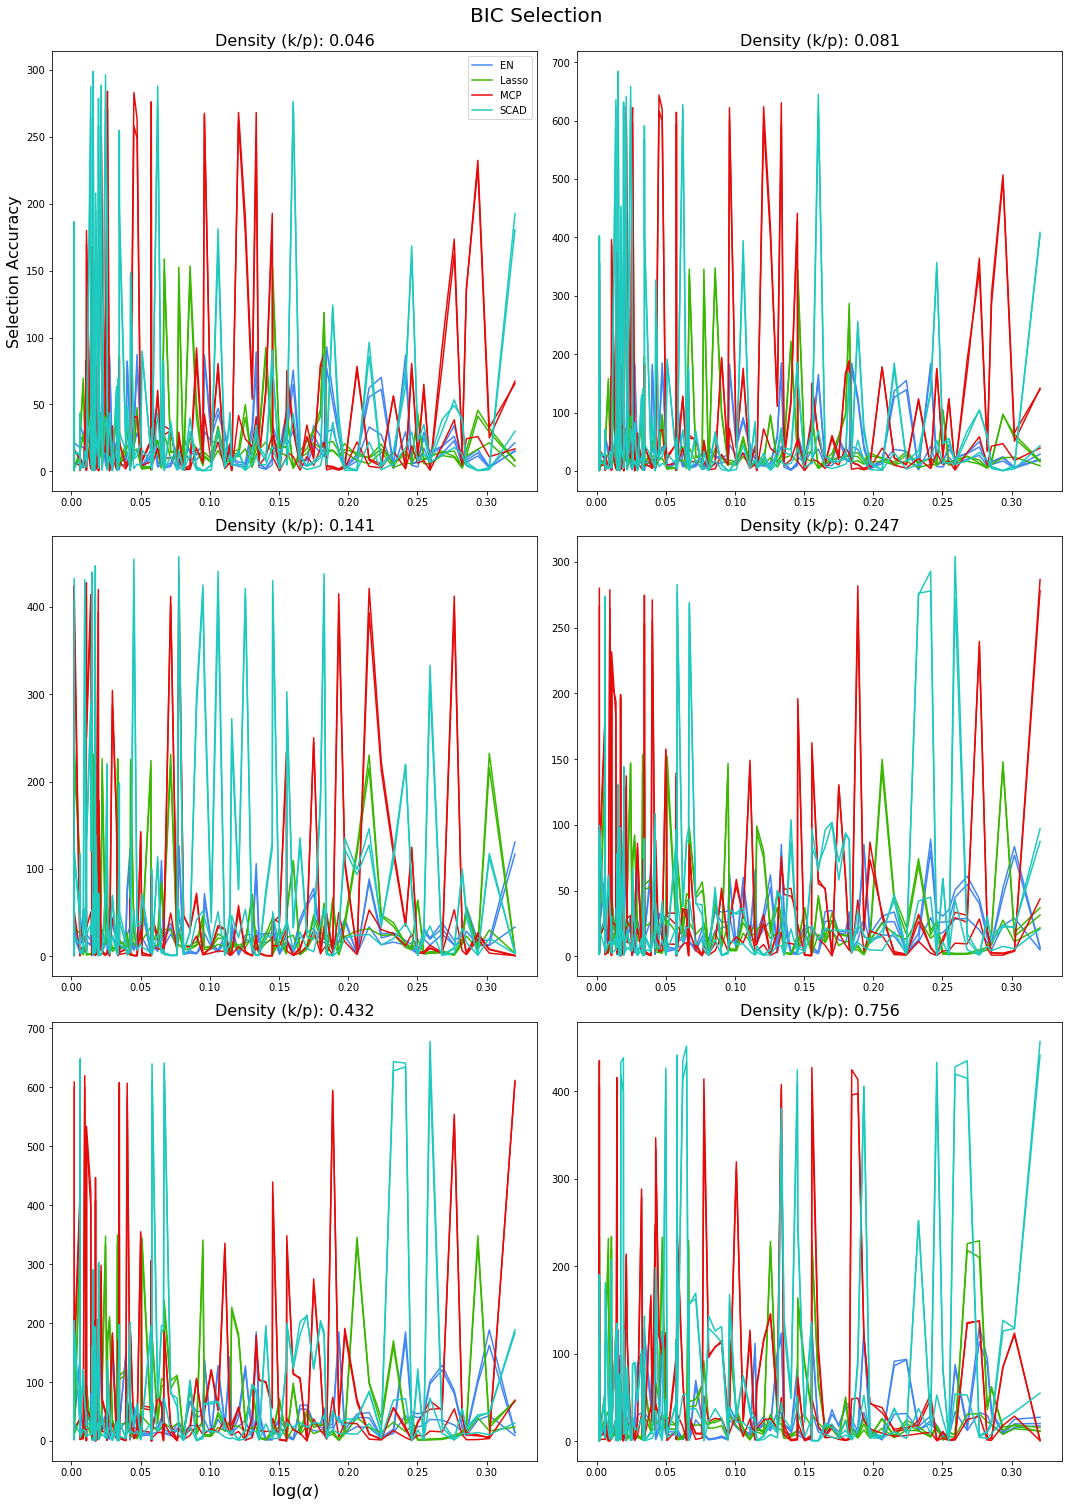

In [54]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = 5
selection_method = 'BIC'
dframe_names = np.unique(bv_df['df_name'].values)

# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c1[0], c2[0], c3[0], c4[0], c5[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):            
            rows = apply_df_filters(bv_df, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            # There are at times non-unique cov_params. We eventually need to investigate this,
            # but for now, take the unique indices
            
            _, unique_rows = np.unique(rows['cov_idx'].values, return_index=True)
            rows = rows.iloc[unique_rows]
            avg_cov_ = avg_cov[rows['cov_idx'].values]
            cov_order = np.argsort(avg_cov_)            
            a.plot(avg_cov_[cov_order], rows['common_bias'].values[cov_order], 
                           label=rows.iloc[j]['df_name'],
                           color=cols[list(dframe_names).index(rows.iloc[j]['df_name'])])
                    
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('Selection Accuracy', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('BIC Selection', fontsize=20)
plt.savefig('BIC_commonbias.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Not sure what's going on here tbh...